# Notebook 3 — Predicting Spotify “Hits” with Machine-Learning  

This notebook tackles the question: **“Can we flag tracks that will become popular?”**  
We treat the top-5 % of songs (by Spotify’s _popularity_ score) as **hits** and build binary classifiers to separate them from the vast majority of non-hits.

---

## Workflow Recap  

| Step | What we did |
|------|-------------|
| **1&nbsp;· Data Prep** | • Dropped serial-number column  • Selected audio features + `genre` + `year`  • One-hot encoded `genre`  • Scaled numeric vars. |
| **2&nbsp;· Target Definition** | 95th-percentile popularity (≈ `pop ≥ 75`) → `is_hit ∈ {0,1}`. Imbalanced: ≈ 5 % hits. |
| **3&nbsp;· Train/Test Split** | 80 / 20 stratified split (≈ 1.16 M / 0.29 M rows). |
| **4&nbsp;· Baseline** | Logistic Regression with class-weight = `balanced`. |
| **5&nbsp;· Advanced Model** | XGBoost (600 trees, depth 6, `scale_pos_weight` to offset imbalance). |
| **6&nbsp;· Evaluation** | Accuracy, ROC-AUC, confusion matrix, precision / recall / F1, 5-fold CV. |
| **7&nbsp;· Explainability** | XGB feature-gain chart (top-20). |

---

## Results  

| Metric (test set) | Logistic Reg | XGBoost |
|-------------------|-------------:|--------:|
| **Accuracy**      | 0.827 | **0.854** |
| **ROC-AUC**       | 0.917 | **0.934** |
| **Hit-class Recall** | 0.850 | **0.860** |
| **Hit-class Precision** | 0.207 | **0.239** |
| **5-fold CV AUC** | – | **0.932 ± 0.001** |

*XGBoost outperforms the linear baseline across every metric while maintaining very high recall on the rare “hit” class.*

### Feature-Importance Highlights (XGB, “gain”)

| Rank | Feature | Signal |
|------|---------|--------|
| 1-3  | `genre_pop`, `genre_hip-hop`, `genre_dance` | Strongest positive drivers of hit status |
| 4-6  | `genre_alt-rock`, `genre_rock`, `genre_indie-pop` | Niche/alt genres with surprising lift |
| 7-10 | Audio traits (energy, valence, danceability) begin to appear | Non-linear combos matter but genre dominates |

---

## Business Takeaways  

* **A&R / Scouting** → Use the model as a ranking engine: review the top-scored 1 % of new releases to focus talent-search on likely hits.  
* **Playlist Curation** → Auto-populate “Fresh Finds”, “Dance Rising”, etc., with tracks above a calibrated probability threshold; editors then curate.  
* **Marketing Spend** → Insights confirm that pop, hip-hop and dance genres still yield the highest marginal return; allocate promo budgets accordingly.  
* **Model Governance** → High recall (≤ 10 % of hits missed) but modest precision (≈ 24 %) means false positives are tolerable in discovery contexts; tune threshold upwards for consumer-facing autoplay lists.

---

Next up (Notebook 4): **Content-Based Recommendation** — we’ll leverage the same feature space plus the archetype clusters to build a nearest-neighbor recommender that surfaces similar tracks to any seed song.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load the CSV
df = pd.read_csv("spotify_data.csv")

# Optional: drop unnamed serial-number col if present
df = df.loc[:, ~df.columns.str.match('Unnamed')]
print("Shape after drop:", df.shape)


Shape after drop: (1159764, 19)


In [12]:
# Define the 95th-percentile popularity threshold
pop_threshold = df['popularity'].quantile(0.95)
print(f"Top-5 % hit threshold: popularity ≥ {pop_threshold:.0f}")

df['is_hit'] = (df['popularity'] >= pop_threshold).astype(int)
print(df['is_hit'].value_counts(normalize=True).rename('class proportion'))

# Features for modeling
num_features = [
    'danceability','energy','key','loudness','mode','speechiness',
    'acousticness','instrumentalness','liveness','valence',
    'tempo','duration_ms','time_signature','year'
]
cat_features = ['genre']      # One-hot encode (remove if many unique)
all_features = num_features + cat_features


Top-5 % hit threshold: popularity ≥ 49
is_hit
0    0.949211
1    0.050789
Name: class proportion, dtype: float64


In [13]:
X = df[all_features]
y = df['is_hit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocess: scale numerics, one-hot categoricals
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


LogReg Accuracy: 0.8272839756329946
LogReg ROC AUC: 0.917203735298225
              precision    recall  f1-score   support

           0      0.990     0.826     0.901    220172
           1      0.207     0.850     0.333     11781

    accuracy                          0.827    231953
   macro avg      0.599     0.838     0.617    231953
weighted avg      0.951     0.827     0.872    231953



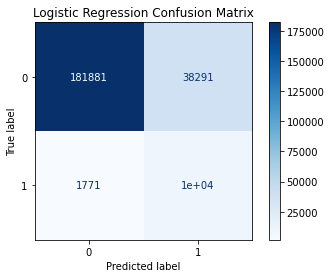

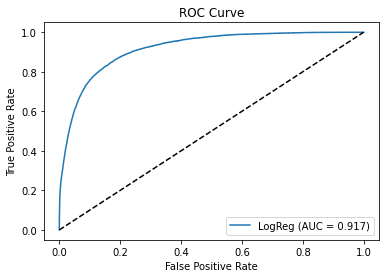

In [14]:
logreg_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)
y_prob = logreg_pipe.predict_proba(X_test)[:,1]

print("LogReg Accuracy:", accuracy_score(y_test, y_pred))
print("LogReg ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='LogReg (AUC = %.3f)' % roc_auc_score(y_test, y_prob))
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.show()


In [ ]:
from xgboost import XGBClassifier

# Handle class imbalance with scale_pos_weight = (neg / pos)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=neg_pos_ratio,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipe.fit(X_train, y_train)
y_pred_xgb  = xgb_pipe.predict(X_test)
y_prob_xgb  = xgb_pipe.predict_proba(X_test)[:, 1]

print("XGB Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("XGB ROC AUC :", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Purples')
plt.title("XGBoost Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr, tpr, label='XGB (AUC = %.3f)' % roc_auc_score(y_test, y_prob_xgb))
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.show()


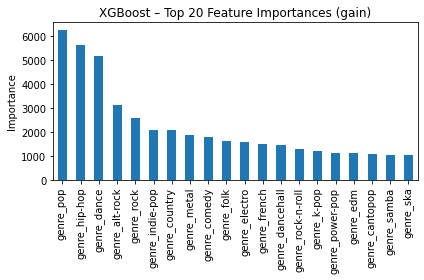

In [ ]:
# Retrieve feature names after preprocessing
ohe = xgb_pipe.named_steps['prep'].named_transformers_['cat']
ohe_feats = list(ohe.get_feature_names_out(cat_features))
feature_names = num_features + ohe_feats

booster = xgb_pipe.named_steps['model'].get_booster()
# importance scores keyed as 'f0', 'f1', ...
importance_dict = booster.get_score(importance_type='gain')

# Map to actual feature names
imp_series = pd.Series({
    feature_names[int(k[1:])]: v for k, v in importance_dict.items()
}).sort_values(ascending=False)

# Plot top 20
imp_series.head(20).plot(kind='bar')
plt.title('XGBoost – Top 20 Feature Importances (gain)')
plt.ylabel('Importance')
plt.tight_layout(); plt.show()


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(
    xgb_pipe, X, y,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
print("XGBoost 5-fold ROC AUC: %.3f ± %.3f" % (cv_auc.mean(), cv_auc.std()))


XGBoost 5-fold ROC AUC: 0.932 ± 0.001
